# Template Matching using NCC and PCE (Peak to Correlation Energy)

In [4]:
from skimage.io import imread
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as patches
from scipy.signal import correlate2d, correlate

In [5]:
orig_img = imread('lena.png')
orig_img = rgb2grey(orig_img)

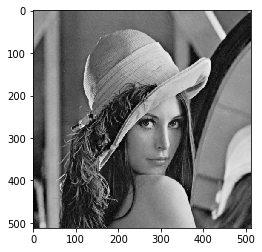

In [6]:
plt.imshow(orig_img, cmap='gray')

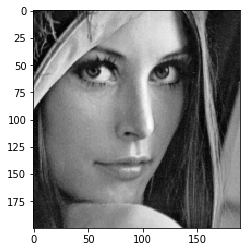

In [7]:
face = orig_img[210:410,210:400]
plt.imshow(face, cmap='gray')

## Calculate NCC (Normalized Cross Correlation) matrix
**Note:** Since no further transformation have been applied on the face image, there should be at least one entry where NCC is 1.

In [8]:
def ncc(img, kernel, shift=(0,0)):
    
    shift_row, shift_col = shift
    
    mean_kernel = np.mean(kernel)
    zero_shifted_kernel = kernel - mean_kernel
     
    img_patch = img[shift_row:shift_row+kernel.shape[0],shift_col:shift_col+kernel.shape[1]]
    mean_img_patch = np.mean(img_patch)
    zero_shifted_img_patch = img_patch - mean_img_patch

    pow_zero_shifted_img_patch = zero_shifted_img_patch * zero_shifted_img_patch
    pow_zero_shifted_kernel = zero_shifted_kernel * zero_shifted_kernel

    numerator = (zero_shifted_img_patch * zero_shifted_kernel).sum()
    denominator = np.sqrt(pow_zero_shifted_img_patch.sum() * pow_zero_shifted_kernel.sum())

    return numerator / denominator

def circular_ncc(img, kernel):
    
    ncc_matrix = np.zeros(img.shape)
    
    for shift_row in range(img.shape[0]):
        for shift_col in range(img.shape[1]):
            shifted_img = np.roll(img, -shift_col, axis=1)
            shifted_img = np.roll(shifted_img, -shift_row, axis=0)
            ncc_matrix[shift_row][shift_col] = ncc(shifted_img, kernel)
    return ncc_matrix

In [9]:
cc_matrix = circular_ncc(orig_img,face)
print(cc_matrix)

[[-0.09271381 -0.09720313 -0.10141722 ... -0.08567971 -0.08771174
  -0.08967603]
 [-0.09592553 -0.10056137 -0.10546497 ... -0.08786043 -0.09027169
  -0.09265147]
 [-0.09925575 -0.10439117 -0.10980485 ... -0.09003855 -0.09290167
  -0.0954775 ]
 ...
 [-0.08126241 -0.08608458 -0.09012322 ... -0.07703054 -0.07797982
  -0.07891499]
 [-0.0848465  -0.08942748 -0.09355654 ... -0.0797559  -0.08112243
  -0.08238279]
 [-0.08880415 -0.09336552 -0.09747492 ... -0.08272244 -0.08445993
  -0.0861064 ]]


## Finally, we also nicely visualize our NCC matrix as 3D plot 

In [22]:
def plot_3d(matrix):
    x = []
    y = []
    z = []

    for (i,j), v in np.ndenumerate(matrix):
        x.append(i)
        y.append(j)
        z.append(v)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x,y,z, cmap=plt.cm.plasma, linewidth=0.2)
    ax.set_zlim(-1., 1.)
    plt.show()

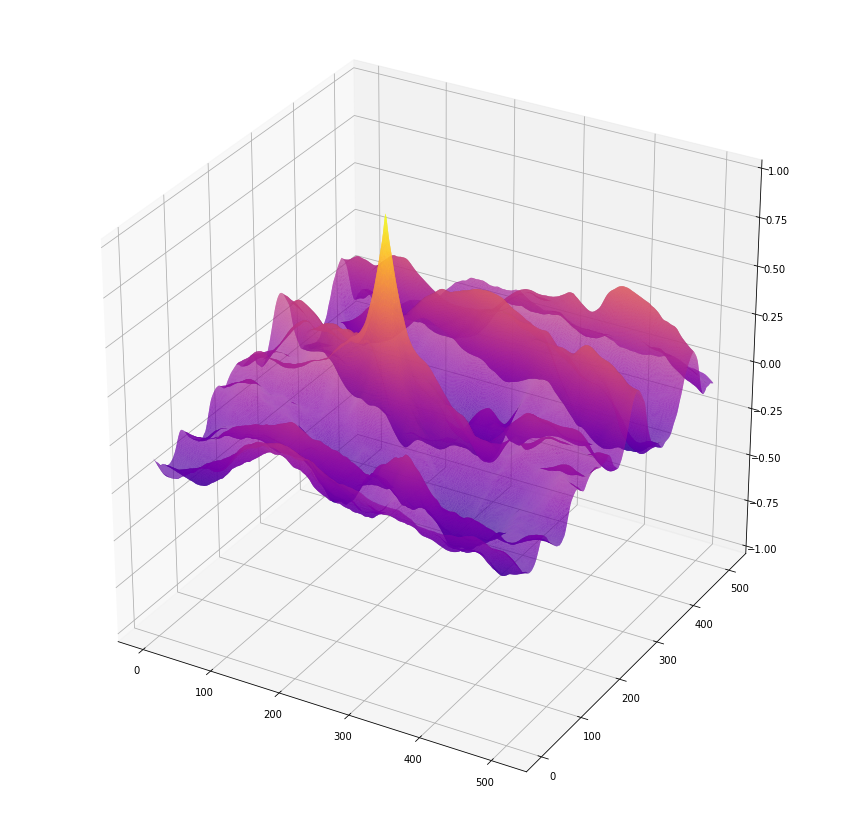

In [11]:
plot_3d(cc_matrix)

## Extract value and position of max peak

In [10]:
shift_y, shift_x = np.unravel_index(cc_matrix.argmax(), cc_matrix.shape)
print("Peak Location: %i / %i" % (shift_x, shift_y))
print("NCC Score: %f" % cc_matrix[shift_y][shift_x])

Peak Location: 210 / 210
NCC Score: 1.000000


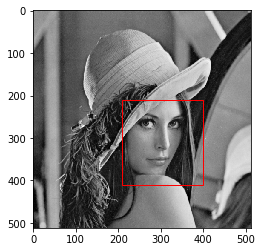

In [11]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(orig_img, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((shift_x,shift_y), face.shape[1], face.shape[0], linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## PCE (Peak to Correlation Energy)

**PCE:** Peak to Correlation Energy (PCE) ratio is the squared correlation divided by sample variance of the circular cross-correlations. To compute it, we first need to consider the matrix of squared cross-correlations. For every "peak" we look at its neighbourhood and divide the peak value(s) by the average value of the neighbouring pixels. Consequently, "unique" peaks will get emphasized whilest uniform regions will be surpressed.

In [63]:
def pce(matrix):
    
    squared_m = matrix*matrix
    
    # We can easily compute the neighbouring pixel's average by correlating the image with
    # a filter matrix. We pick a kernel size of 11x11. 
    filter = np.full((11,11), 1/(11*11-1)) # Number of elements in its neighbourhood
    filter[5,5] = 0

    # Note: 
    # - "Wrap" to enforce circular boundary conditions
    # - "Same" to preserve the original size. Furthermore, the filter gets center on the image.
    #   This is very important since we want to consider the neighbourhood AROUND the peak.
    pce = correlate2d(squared_m, filter, mode='same', boundary='wrap')
    
    # Additional information:
    # Correlate / Correlate2d (WITHOUT mode "same")
    # These functions do NOT "center" the filter on the image. Hence, we only consider neighbours
    # on the right hand side of the peak. To solve this issue we can simply shift the final PCE matrix.
    # 1D example:
    # Signal: 1 2 1    Kernel: 1 1 1  ==> Output of correlate (with zero padding): 1 3 4 3 1
    # Expected result: 3 4 3 
    # pce = np.roll(pce,-5, axis=1)
    # pce = np.roll(pce,-5, axis=0)
    
    return pce

In [64]:
pce_matrix = pce(cc_matrix)
print(pce_matrix)
print(pce_matrix.shape)

[[0.00945029 0.01015158 0.01092499 ... 0.00757417 0.00815045 0.0087879 ]
 [0.01017314 0.01094765 0.01178346 ... 0.00804783 0.00870754 0.00942979]
 [0.01094705 0.01179514 0.012694   ... 0.00855968 0.00930852 0.01012066]
 ...
 [0.00756901 0.00806733 0.00865863 ... 0.00634368 0.00670564 0.00712134]
 [0.00815316 0.00871516 0.00936467 ... 0.00672838 0.00715553 0.00763917]
 [0.0087777  0.00940754 0.01011832 ... 0.00713591 0.00763443 0.00819199]]
(512, 512)


In [65]:
shift_y, shift_x = np.unravel_index(pce_matrix.argmax(), pce_matrix.shape)
print("Peak Location: %i / %i" % (shift_x, shift_y))
print("PCE Score: %f" % pce_matrix[shift_y][shift_x])

Peak Location: 210 / 210
PCE Score: 0.702434


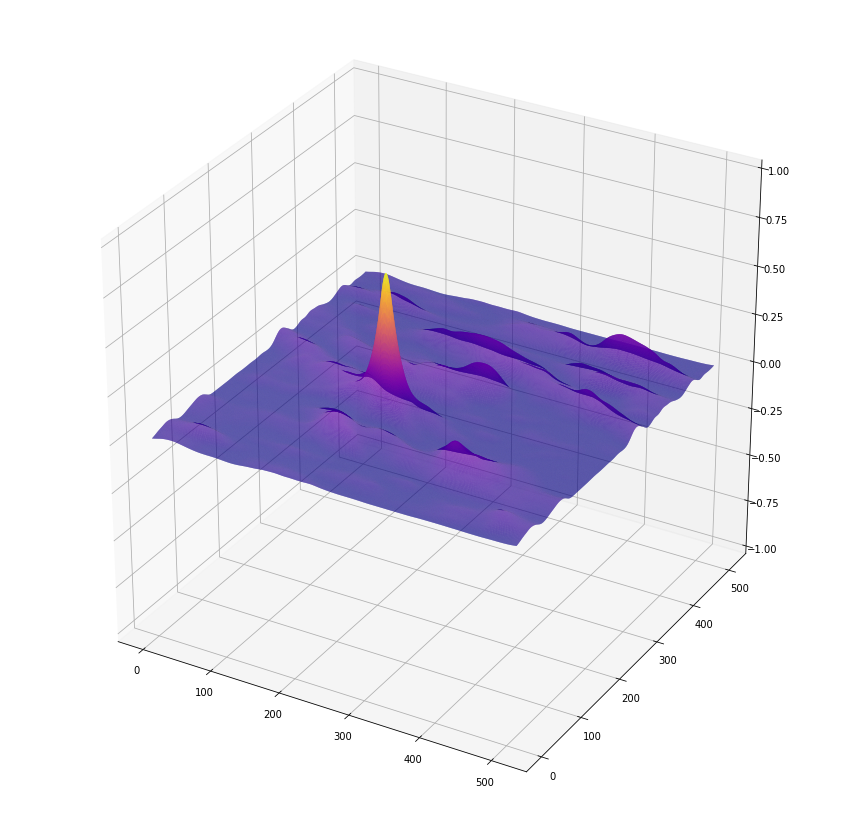

In [66]:
plot_3d(pce_matrix)